In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names
train = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=col_names)
test = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=col_names)
y_test = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=['RUL'])

In [3]:
def add_remaining_useful_life(df):
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [4]:
X_train = train.iloc[:,0:27]
y_train = X_train.pop('RUL')
X_test = test.groupby('unit_nr').last().reset_index()

In [5]:
y_train = y_train.clip(upper=125)

In [6]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 26)
(20631, 378)


In [9]:
svr_f = SVR(kernel='linear')
svr_f.fit(X_train_transformed, y_train)


SVR(kernel='linear')

In [10]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [12]:
lm = LinearRegression()
lm.fit(X_train_transformed, y_train)

y_hat_train1 = lm.predict(X_train_transformed)
evaluate(y_train, y_hat_train1, 'train')

y_hat_test1 = lm.predict(X_test_transformed)
evaluate(y_test, y_hat_test1)

train set RMSE:17.107773118428938, R2:0.8314674014634774
test set RMSE:19.923692558535752, R2:0.7701311522496818


In [8]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

In [10]:
y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test, y_hat_test)

train set RMSE:17.84330527350101, R2:0.8166640791037745
test set RMSE:20.841517444011522, R2:0.7484645920172335


In [13]:
from sklearn.feature_selection import SelectFromModel
select_features = SelectFromModel(svr_f, threshold='mean', prefit=True)
select_features.get_support()
feature_names = poly.get_feature_names()

print('Original features:\n', X_train.columns)
print('Best features:\n', np.array(feature_names)[select_features.get_support()])
np.array(feature_names)[select_features.get_support()].shape

Original features:
 Index(['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21'],
      dtype='object')
Best features:
 ['x1' 'x6' 'x7' 'x8' 'x11' 'x12' 'x13' 'x15' 'x16' 'x17' 'x18' 'x19' 'x21'
 'x24' 'x25' 'x0 x1' 'x0 x12' 'x0 x13' 'x0 x18' 'x1^2' 'x1 x2' 'x1 x6'
 'x1 x7' 'x1 x8' 'x1 x10' 'x1 x12' 'x1 x13' 'x1 x15' 'x1 x17' 'x1 x18'
 'x1 x19' 'x1 x21' 'x1 x25' 'x2 x6' 'x2 x13' 'x2 x18' 'x3 x8' 'x3 x24'
 'x6 x10' 'x6 x12' 'x6 x13' 'x6 x16' 'x6 x17' 'x6 x18' 'x7 x13' 'x7 x17'
 'x7 x18' 'x8 x10' 'x8 x12' 'x8 x13' 'x8 x15' 'x8 x17' 'x8 x18' 'x10 x11'
 'x10 x13' 'x10 x15' 'x10 x16' 'x10 x18' 'x10 x19' 'x10 x21' 'x10 x24'
 'x10 x25' 'x11 x12' 'x11 x13' 'x11 x15' 'x11 x17' 'x11 x18' 'x11 x19'
 'x12^2' 'x12 x13' 'x12 x15' 'x12 x16' 'x12 x17' 'x12 x18' 'x12 x19'
 'x12 x24' 'x13^2' 'x13 x15' 'x13 x16' 'x13

(104,)

In [13]:
svr = SVR(kernel='linear')
svr.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

y_hat_train = svr.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test)

train set RMSE:17.84585888284083, R2:0.8166115998334554
test set RMSE:20.900922450021554, R2:0.7470286353631941


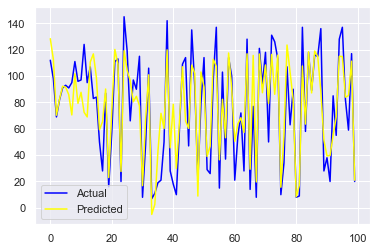

In [26]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [14]:
lm = LinearRegression()
lm.fit(X_train_transformed[:, select_features.get_support()], y_train_clipped)

y_hat_train1 = lm.predict(X_train_transformed[:, select_features.get_support()])
evaluate(y_train_clipped, y_hat_train1, 'train')

y_hat_test1 = lm.predict(X_test_transformed[:, select_features.get_support()])
evaluate(y_test, y_hat_test1)

train set RMSE:17.185361982153875, R2:0.8299352435271388
test set RMSE:19.909980175536536, R2:0.7704474555633745


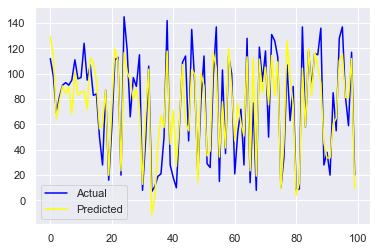

In [27]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test1,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [18]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, train_size=0.80, random_state=42)  

def train_val_group_split(X, y, gss, groups, print_groups=True):
    
    for idx_train, idx_val in gss.split(X, y, groups=groups):
        if print_groups:
            print('train_split_engines', train.iloc[idx_train]['unit_nr'].unique(), '\n')
            print('validate_split_engines', train.iloc[idx_val]['unit_nr'].unique(), '\n')

        X_train_split = X[idx_train].copy()
        y_train_split = y.iloc[idx_train].copy()
        X_val_split = X[idx_val].copy()
        y_val_split = y.iloc[idx_val].copy()
    return X_train_split, y_train_split, X_val_split, y_val_split



In [19]:
X_trainn= X_train_transformed[:, select_features.get_support()]
split_result = train_val_group_split(X_trainn, y_train_clipped, gss, train['unit_nr'])
X_train_split, y_train_clipped_split, X_val_split, y_val_clipped_split = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [20]:
split_result = train_val_group_split(X_train_scaled, y_train_clipped, gss, train['unit_nr'], print_groups=True)
X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = split_result

train_split_engines [  2   3   4   6   7   8   9  10  12  14  15  16  17  18  20  21  22  24
  25  26  27  28  29  30  33  35  36  37  38  39  41  42  43  44  47  48
  49  50  51  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  72  73  75  76  79  80  82  83  85  86  87  88  89  90  92
  93  94  95  96  97  98  99 100] 

validate_split_engines [ 1  5 11 13 19 23 31 32 34 40 45 46 54 71 74 77 78 81 84 91] 



In [30]:
train_cols = setting_names+sensor_names
input_dim = len(train_cols)

model = Sequential()
model.add(Dense(16, input_dim=26, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [35]:

epochs = 30

history = model.fit(X_train_split_scaled, y_train_clipped_split_scaled,
                    validation_data=(X_val_split_scaled, y_val_clipped_split_scaled),
                    epochs=epochs)

Epoch 1/30
518/518 [==============================] - 1s 2ms/step - loss: 273.6807 - val_loss: 225.9578
Epoch 2/30
518/518 [==============================] - 1s 2ms/step - loss: 268.4944 - val_loss: 229.3707
Epoch 3/30
518/518 [==============================] - 1s 2ms/step - loss: 265.2763 - val_loss: 227.0773
Epoch 4/30
518/518 [==============================] - 1s 2ms/step - loss: 263.0693 - val_loss: 247.9453
Epoch 5/30
518/518 [==============================] - 1s 2ms/step - loss: 259.7890 - val_loss: 225.5080
Epoch 6/30
518/518 [==============================] - 1s 2ms/step - loss: 257.7368 - val_loss: 229.1231
Epoch 7/30
518/518 [==============================] - 1s 2ms/step - loss: 256.8985 - val_loss: 237.5575
Epoch 8/30
518/518 [==============================] - 1s 2ms/step - loss: 255.0780 - val_loss: 241.4351
Epoch 9/30
518/518 [==============================] - 1s 2ms/step - loss: 255.1971 - val_loss: 228.5941
Epoch 10/30
518/518 [==============================] - 1s 2ms/st

In [36]:
y_hat_train3 = model.predict(X_train_scaled)
evaluate(y_train, y_hat_train3, 'train')

y_hat_test3 = model.predict(X_test_scaled)
evaluate(y_test, y_hat_test3)

train set RMSE:47.668969190537474, R2:0.5210459947654187
test set RMSE:18.399189858909878, R2:0.8039630858843007


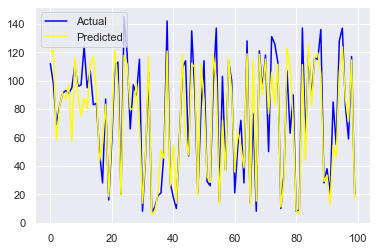

In [37]:
plt.plot(y_test,c='blue',label='Actual')
plt.plot(y_hat_test3,c='yellow',label='Predicted')
plt.legend()
plt.show()

In [14]:
# choose the model
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor()
# set up 5-fold cross-validation
from sklearn import model_selection
cv = model_selection.KFold(5)
# pipeline standardization and model
from sklearn.pipeline import Pipeline
pipeline = Pipeline(steps=[('standardize', preprocessing.StandardScaler())
                           , ('model', gb) ])

In [13]:
# tune the model
my_alpha = [.5, .75, .9]
my_n_estimators= [500]
my_learning_rate = [0.005, .01]
my_max_depth = [4, 5, 6]
# run the model using gridsearch, select the model with best search
from sklearn.model_selection import GridSearchCV
optimized_gb = GridSearchCV(estimator=pipeline
                            , cv=cv
                            , param_grid =dict(model__max_depth = my_max_depth, model__n_estimators = my_n_estimators,
                                              model__learning_rate = my_learning_rate, model__alpha = my_alpha)
                            , scoring = 'neg_mean_squared_error'
                            , verbose = 1
                            , n_jobs = -1
                           )
optimized_gb.fit(X_train_transformed[:, select_features.get_support()], y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('standardize', StandardScaler()),
                                       ('model', GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.5, 0.75, 0.9],
                         'model__learning_rate': [0.005, 0.01],
                         'model__max_depth': [4, 5, 6],
                         'model__n_estimators': [500]},
             scoring='neg_mean_squared_error', verbose=1)

In [14]:
# show the best model estimators
print(optimized_gb.best_estimator_)
# evaluate metrics on holdout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred = optimized_gb.predict(X_test_transformed[:, select_features.get_support()])
print("Gradient Boosting Mean Squared Error: ", mean_squared_error(y_test, y_pred))
print("Gradient Boosting Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))
print("Gradient Boosting r-squared: ", r2_score(y_test, y_pred))

Pipeline(steps=[('standardize', StandardScaler()),
                ('model',
                 GradientBoostingRegressor(alpha=0.5, learning_rate=0.005,
                                           max_depth=4, n_estimators=500))])
Gradient Boosting Mean Squared Error:  357.8195753598182
Gradient Boosting Mean Absolute Error:  14.559131129898253
Gradient Boosting r-squared:  0.7927929385288743


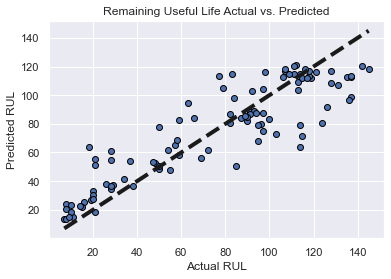

In [15]:
# plot actual vs predicted Remaining Useful Life for the best model (GBM)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [15]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, HuberRegressor, Lasso
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR  
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

,R-squared
Lasso,0.720427
AdaBoost,0.768853
Huber,0.826279
Ridge,0.826926
Linear,0.827933
BayesianRidge,0.828186
SVM,0.832355
Neural Network,0.853200
Bagging,0.853565
RandomForest,0.867531


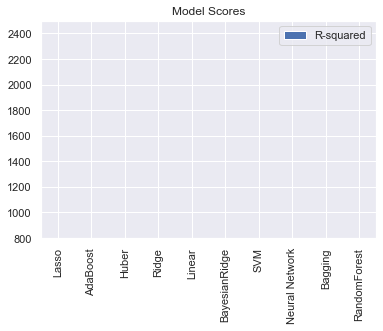

In [16]:
def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        mse = make_scorer(r2_score)
        mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
        scores = [mse_val_score.mean()]
        return scores
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R-squared"] 
    results = results.sort_values(by=["R-squared"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([800, 2500])
    return results

analyse_regression_models(X_train_transformed[:, select_features.get_support()], y_train)

C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

,R-squared
Lasso,0.720464
AdaBoost,0.747688
SVM,0.816892
Huber,0.823990
Linear,0.827026
Ridge,0.827268
BayesianRidge,0.827992
Neural Network,0.850436
Bagging,0.867226
RandomForest,0.881011


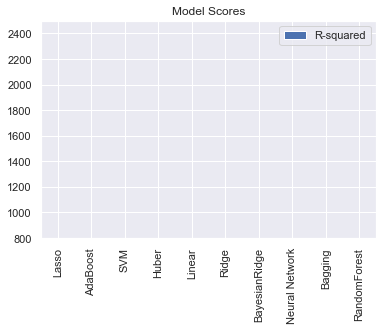

In [17]:
def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        mse = make_scorer(r2_score)
        mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
        scores = [mse_val_score.mean()]
        return scores
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R-squared"] 
    results = results.sort_values(by=["R-squared"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([800, 2500])
    return results

analyse_regression_models(X_train_transformed, y_train)

C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,R-squared
SVM,-0.125742
Neural Network,0.530747
Huber,0.732636
AdaBoost,0.737277
Lasso,0.758235
BayesianRidge,0.772866
Ridge,0.772887
Linear,0.773219
Bagging,0.881611
RandomForest,0.898224


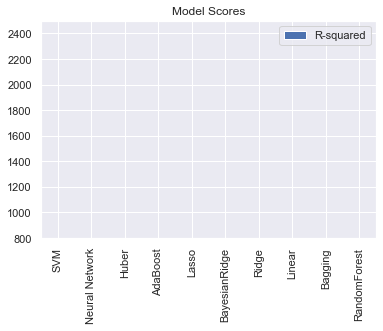

In [18]:
def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        mse = make_scorer(r2_score)
        mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
        scores = [mse_val_score.mean()]
        return scores
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R-squared"] 
    results = results.sort_values(by=["R-squared"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([800, 2500])
    return results

analyse_regression_models(X_train, y_train)

C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

,R-squared
Lasso,0.709836
AdaBoost,0.742032
Huber,0.772632
Linear,0.773219
BayesianRidge,0.773266
Ridge,0.773282
Neural Network,0.813626
SVM,0.817988
Bagging,0.883901
RandomForest,0.897658


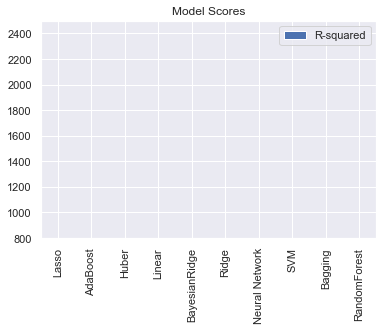

In [19]:
def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        mse = make_scorer(r2_score)
        mse_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=mse)
        scores = [mse_val_score.mean()]
        return scores
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["R-squared"] 
    results = results.sort_values(by=["R-squared"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([800, 2500])
    return results

analyse_regression_models(X_train_scaled, y_train)

In [20]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [21]:
def get_RUL(engine_data):
    
    # The binary_class will be 0 if RUL > 30. The binary_class will be 1 if RUL <= 30
    engine_data["binary_class"] = engine_data["RUL"].map(lambda x: 1 if x <= 30 else 0)
    
    # The multi_class will be 0 if RUL > 30. The multi_class will be 1 if  15 < RUL <= 30. 
    # The multi_class will be 2 if RUL <= 15
    engine_data["multi_class"] = engine_data["RUL"].map(lambda x: 2 if x <= 15 else 1 if x<= 30 else 0)
    return engine_data

train_labels = get_RUL(train.copy(deep=True))
RUL_train = train_labels["RUL"]
binary_class_train = train_labels["binary_class"]
multi_class_train = train_labels["multi_class"]

train_labels

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL,binary_class,multi_class
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1,2
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1,2
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1,2


In [22]:
# Label Test Data

# RUL_FD001.txt contains the RUL for the last cycle for all the engines in the test data set
# In the test set, the time series ends some time before the system failure.
remaining_RUL_test = pd.read_csv("RUL_FD001.txt", header=None)
remaining_RUL_test["unit_nr"] = remaining_RUL_test.index + 1


def get_RUL_test(engine_data_test, remaining_RUL_test):
    # Get the last cycle for all the engines in the test data set
    last_cycle = engine_data_test.copy(deep=True).groupby(['unit_nr'])["time_cycles"].max().reset_index()
    
    # Since remaining_RUL_test contains RUL only for the last cycle in the test data set, 
    # we only keep the last cycle for each engine in the test data set
    final = pd.merge(last_cycle, engine_data_test.copy(deep=True), how="inner", on=["unit_nr", "time_cycles"])
    final = pd.merge(final, remaining_RUL_test, how="inner", on=["unit_nr"])
    final["RUL"] = final[0]
    # The binary_class will be 0 if RUL > 30. The binary_class will be 1 if RUL <= 30
    final["binary_class"] = final["RUL"].map(lambda x: 1 if x <= 30 else 0)
    # The multi_class will be 0 if RUL > 30. The multi_class will be 1 if  15 < RUL <= 30. 
    # The multi_class will be 2 if RUL <= 15
    final["multi_class"] = final["RUL"].map(lambda x: 2 if x <= 15 else 1 if x<= 30 else 0)
    return final

test_labels = get_RUL_test(test.copy(deep=True), remaining_RUL_test)
RUL_test = test_labels["RUL"]
binary_class_test = test_labels["binary_class"]
multi_class_test = test_labels["multi_class"]

test_labels

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_16,s_17,s_18,s_19,s_20,s_21,0,RUL,binary_class,multi_class
0,1,31,-0.0006,0.0004,100.0,518.67,642.58,1581.22,1398.91,14.62,...,0.03,393,2388,100.0,38.81,23.3552,112,112,0,0
1,2,49,0.0018,-0.0001,100.0,518.67,642.55,1586.59,1410.83,14.62,...,0.03,391,2388,100.0,38.81,23.2618,98,98,0,0
2,3,126,-0.0016,0.0004,100.0,518.67,642.88,1589.75,1418.89,14.62,...,0.03,395,2388,100.0,38.93,23.2740,69,69,0,0
3,4,106,0.0012,0.0004,100.0,518.67,642.78,1594.53,1406.88,14.62,...,0.03,395,2388,100.0,38.58,23.2581,82,82,0,0
4,5,98,-0.0013,-0.0004,100.0,518.67,642.27,1589.94,1419.36,14.62,...,0.03,394,2388,100.0,38.75,23.4117,91,91,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,97,-0.0006,0.0003,100.0,518.67,642.30,1590.88,1397.94,14.62,...,0.03,391,2388,100.0,38.96,23.4606,137,137,0,0
96,97,134,0.0013,-0.0001,100.0,518.67,642.59,1582.96,1410.92,14.62,...,0.03,395,2388,100.0,38.61,23.2953,82,82,0,0
97,98,121,0.0017,0.0001,100.0,518.67,642.68,1599.51,1415.47,14.62,...,0.03,394,2388,100.0,38.76,23.3608,59,59,0,0
98,99,97,0.0047,-0.0000,100.0,518.67,642.00,1585.03,1397.98,14.62,...,0.03,391,2388,100.0,38.95,23.3595,117,117,0,0


KNeighbors
SVC
GaussianProcess
GaussianNB
QuadraticDiscriminantAnalysis


C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Neural Network
AdaBoost
Decision Tree
RandomForest


,Accuracy
GaussianProcess,0.964180
SVM,0.963647
AdaBoost,0.960012
Neural Network,0.959624
RandomForest,0.959527
KNeighbors,0.958461
Decision Tree,0.957782
GaussianNB,0.928554
QuadraticDiscriminantAnalysis,0.683153


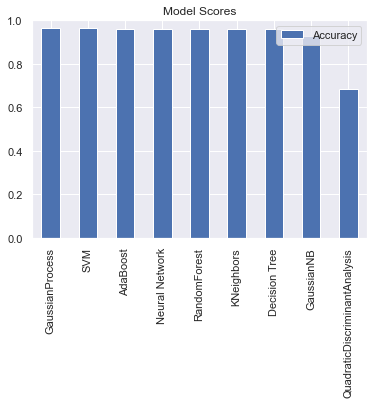

In [23]:
def analyse_binary_classification_models(train, labels):
    results = {}
    
    def test_model(clf):
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        accuracy = make_scorer(accuracy_score)
        accuracy_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=accuracy)
        scores = [accuracy_val_score.mean()]
        return scores
    
    clf = KNeighborsClassifier(3)
    print("KNeighbors")
    results["KNeighbors"] = test_model(clf)
    
    clf = SVC()
    print("SVC")
    results["SVM"] = test_model(clf)
    
    clf = GaussianProcessClassifier()
    print("GaussianProcess")
    results["GaussianProcess"] = test_model(clf)
    
    clf = GaussianNB()
    print("GaussianNB")
    results["GaussianNB"] = test_model(clf)
    
    clf = QuadraticDiscriminantAnalysis()
    print("QuadraticDiscriminantAnalysis")
    results["QuadraticDiscriminantAnalysis"] = test_model(clf)
    
    clf = MLPClassifier(alpha=1)
    print("Neural Network")
    results["Neural Network"] = test_model(clf)
    
    clf = AdaBoostClassifier()
    print("AdaBoost")
    results["AdaBoost"] = test_model(clf)
    
    clf = DecisionTreeClassifier(max_depth=5)
    print("Decision Tree")
    results["Decision Tree"] = test_model(clf)
    
    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    print("RandomForest")
    results["RandomForest"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["Accuracy"] 
    results = results.sort_values(by=["Accuracy"], ascending=False)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0, 1])
    return results

analyse_binary_classification_models(X_train_transformed[:, select_features.get_support()], binary_class_train)

In [24]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier


cv = KFold(n_splits=2, shuffle=True, random_state=20)

# Parameter list for tuning
parameters = {
    'learning_rate': [0.7, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [12, 25, 50, 100]
}

# Initialise AdaBoostClassifier
clf = AdaBoostClassifier(random_state=20)

accuracy = make_scorer(accuracy_score)

# Perform Grid Search using accuracy as the scoring method
grid_obj = GridSearchCV(clf, parameters, cv=cv, scoring=accuracy)

# Fit the grid search to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train_transformed[:, select_features.get_support()], binary_class_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_ 
print(best_clf)

best_clf.fit(X_train_transformed[:, select_features.get_support()], binary_class_train)

binary_class_predictions = best_clf.predict(X_test_transformed[:, select_features.get_support()])

print("Accuracy: " + str(accuracy_score(binary_class_predictions, binary_class_test)))

AdaBoostClassifier(learning_rate=0.7, n_estimators=100, random_state=20)
Accuracy: 0.92


KNeighbors
SVC
GaussianProcess
GaussianNB
QuadraticDiscriminantAnalysis


C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mbnes\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Neural Network
AdaBoost
Decision Tree
RandomForest


,Accuracy
GaussianProcess,0.942756
Neural Network,0.938103
AdaBoost,0.937909
SVM,0.936939
KNeighbors,0.932529
RandomForest,0.930541
Decision Tree,0.929620
GaussianNB,0.881004
QuadraticDiscriminantAnalysis,0.650385


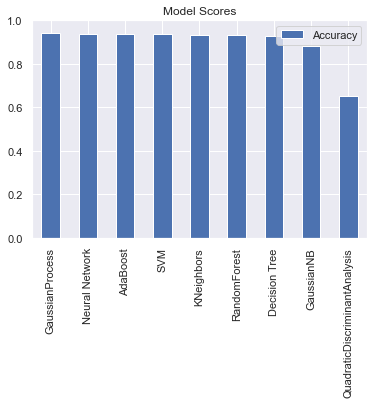

In [25]:

# Multiclass Model selection (Multiclass classification)

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier



def analyse_multiclass_classification_models(train, labels):
    results = {}
    
    def test_model(clf):
        clf = OneVsRestClassifier(clf)
        cv = KFold(n_splits=2, shuffle=True, random_state=20)
        accuracy = make_scorer(accuracy_score)
        accuracy_val_score = cross_val_score(clf, train, labels, cv=cv, scoring=accuracy)
        scores = [accuracy_val_score.mean()]
        return scores
    
    clf = KNeighborsClassifier(3)
    print("KNeighbors")
    results["KNeighbors"] = test_model(clf)
    
    clf = SVC()
    print("SVC")
    results["SVM"] = test_model(clf)
    
    clf = GaussianProcessClassifier()
    print("GaussianProcess")
    results["GaussianProcess"] = test_model(clf)
    
    clf = GaussianNB()
    print("GaussianNB")
    results["GaussianNB"] = test_model(clf)
    
    clf = QuadraticDiscriminantAnalysis()
    print("QuadraticDiscriminantAnalysis")
    results["QuadraticDiscriminantAnalysis"] = test_model(clf)
    
    clf = MLPClassifier(alpha=1)
    print("Neural Network")
    results["Neural Network"] = test_model(clf)
    
    clf = AdaBoostClassifier()
    print("AdaBoost")
    results["AdaBoost"] = test_model(clf)
    
    clf = DecisionTreeClassifier(max_depth=5)
    print("Decision Tree")
    results["Decision Tree"] = test_model(clf)
    
    clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    print("RandomForest")
    results["RandomForest"] = test_model(clf)
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["Accuracy"] 
    results = results.sort_values(by=["Accuracy"], ascending=False)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([0, 1])
    return results

analyse_multiclass_classification_models(X_train_transformed[:, select_features.get_support()], multi_class_train)

In [26]:
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier


cv = KFold(n_splits=2, shuffle=True, random_state=20)

# Parameter list for tuning
parameters = {
    'learning_rate': [0.7, 1],
    'algorithm': ['SAMME', 'SAMME.R'],
    'n_estimators': [200, 50]
}

# Initialise AdaBoostClassifier
clf = AdaBoostClassifier(random_state=20)

accuracy = make_scorer(accuracy_score)

# Perform Grid Search using accuracy as the scoring method
grid_obj = GridSearchCV(clf, parameters, cv=cv, scoring=accuracy)

# Fit the grid search to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train_transformed[:, select_features.get_support()], multi_class_train)

# Get the best estimator
best_clf = grid_fit.best_estimator_ 
best_clf = OneVsRestClassifier(best_clf)
print(best_clf)

best_clf.fit(X_train_transformed[:, select_features.get_support()], multi_class_train)

multi_class_predictions = best_clf.predict(X_test_transformed[:, select_features.get_support()])

print("Accuracy: " + str(accuracy_score(multi_class_predictions, multi_class_test)))

OneVsRestClassifier(estimator=AdaBoostClassifier(algorithm='SAMME',
                                                 learning_rate=1,
                                                 n_estimators=200,
                                                 random_state=20))
Accuracy: 0.89
